In [1]:
import pandas as pd
import numpy as np

In [2]:
train_path = ('../input/plant-seedlings-classification/train')
test_path = ('../input/plant-seedlings-classification/test')

In [3]:
import cv2

im = cv2.imread('../input/plant-seedlings-classification/train/Black-grass/0050f38b3.png')
print(type(im))
print(im.shape)

<class 'numpy.ndarray'>
(196, 196, 3)


In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

image_size = [196,196,3]
inception = InceptionV3(input_shape = image_size, weights = 'imagenet', include_top = False)

87916544/87910968 [==============================] - 3s 0us/step


In [5]:
for layer in inception.layers:
    layer.trinable = False

In [6]:
from glob import glob
folders = glob('../input/plant-seedlings-classification/train/*')

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

In [8]:
x = Flatten()(inception.output)

In [9]:
#add a fully conected layer with 12 hidden untis and softmax activation #
prediction = Dense(12, activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./196, #Normalization#
                                   shear_range = 0.2, #for randomly applying shearing transformations#
                                   zoom_range = 0.2, #for randomly zooming inside pictures#
                                   horizontal_flip = True, #is for randomly flipping half of the images horizontally#
                                   validation_split=0.2)  #set validation split#    



In [11]:
training_set = train_datagen.flow_from_directory(train_path, #directory for training images#
                                                 target_size = (196, 196), #all images will be resized to 250x250#
                                                 batch_size = 32, #flow images in batches of 20#
                                                 class_mode = 'categorical', #binary_crossentropy loss if data were binary#
                                                 seed = 42, #seed: Random seed for applying random image augmentation and shuffling the order of the image#
                                                 subset = 'training')

validation_set = train_datagen.flow_from_directory(train_path, 
                                            target_size = (196, 196), 
                                            batch_size = 32, 
                                            class_mode = 'categorical',
                                            seed = 42,
                                             subset = 'validation')

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [12]:
batch_size = 32 #look how much if there is the correct amount#

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

r = model.fit(
    training_set,
    steps_per_epoch = training_set.samples // batch_size,
    validation_data = validation_set, 
    validation_steps = validation_set.samples // batch_size,
    epochs = 20,
    callbacks =[earlystopping])

Epoch 1/20
118/118 [==============================] - 765s 6s/step - loss: 2.5781 - accuracy: 0.3558 - val_loss: 64774.0391 - val_accuracy: 0.0550
Epoch 2/20
118/118 [==============================] - 741s 6s/step - loss: 1.4169 - accuracy: 0.6680 - val_loss: 49780.0703 - val_accuracy: 0.1616
Epoch 3/20
118/118 [==============================] - 735s 6s/step - loss: 0.9106 - accuracy: 0.7507 - val_loss: 54.3910 - val_accuracy: 0.6034
Epoch 4/20
118/118 [==============================] - 743s 6s/step - loss: 0.6603 - accuracy: 0.8051 - val_loss: 1.0429 - val_accuracy: 0.7101
Epoch 5/20
118/118 [==============================] - 737s 6s/step - loss: 0.7471 - accuracy: 0.7944 - val_loss: 24.6325 - val_accuracy: 0.7069
Epoch 6/20
118/118 [==============================] - 743s 6s/step - loss: 0.4214 - accuracy: 0.8471 - val_loss: 2.7319 - val_accuracy: 0.8685
Epoch 7/20
118/118 [==============================] - 736s 6s/step - loss: 0.3218 - accuracy: 0.8839 - val_loss: 1.3572 - val_accura

In [13]:
#witout valid#
valid_loss, valid_acc = model.evaluate_generator(validation_set, steps=len(validation_set))
print(f"Final validation accuracy: {valid_acc*100:.2f}%")

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Final validation accuracy: 89.33%


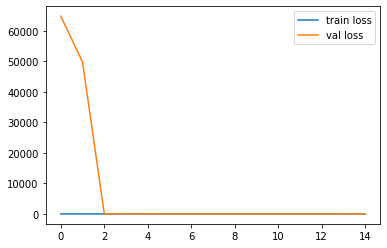

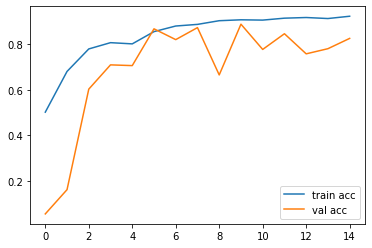

<Figure size 432x288 with 0 Axes>

In [14]:
# plotting the loss
import matplotlib.pyplot as plt

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plotting the accuracy


plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [15]:
test_datagen = ImageDataGenerator(rescale = 1./196)

test_set =  test_datagen.flow_from_directory(
        directory= '/kaggle/input/plant-seedlings-classification/',
        classes=['test'],
        target_size=(196, 196),
        batch_size=32,
        class_mode='categorical')

Found 794 images belonging to 1 classes.


In [16]:
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]   


yhat_predict = model.predict(test_set, steps=test_set.samples)
class_list = []
for i in range(yhat_predict.shape[0]):
    y_class = yhat_predict[i,:].argmax(axis=-1)
    class_list.append(species_list[y_class])
    
    
submission = pd.DataFrame()
submission['file'] = test_set.filenames
submission['file'] = submission['file'].str.replace(r'test/', '')
submission['species'] = class_list

submission.to_csv('submission.csv', index=False)

In [17]:
submission.head()

,file,species
0,0021e90e4.png,Shepherds Purse
1,003d61042.png,Fat Hen
2,007b3da8b.png,Charlock
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Common wheat
